# Technical setup
> Skip this section

In [97]:
# @formatter:off

In [98]:
%%time
%reload_ext autoreload
%autoreload 2
# @formatter:on

CPU times: user 4.71 ms, sys: 6.64 ms, total: 11.4 ms
Wall time: 11.4 ms


# Parameters

In [99]:
symbol = 'ETHUSDT'
symbol_k_lines_interval = '1s'
symbol_ask_bid_price_difference = 0.01

# Ticks

,timestamp,bid_price,ask_price
0,1677628800000,1605.24,1605.25
1,1677628801000,1605.46,1605.47
2,1677628802000,1605.46,1605.47
3,1677628803000,1605.46,1605.47
4,1677628804000,1605.47,1605.48
...,...,...,...
86395,1681775995000,2074.00,2074.01
86396,1681775996000,2074.00,2074.01
86397,1681775997000,2074.00,2074.01
86398,1681775998000,2074.00,2074.01


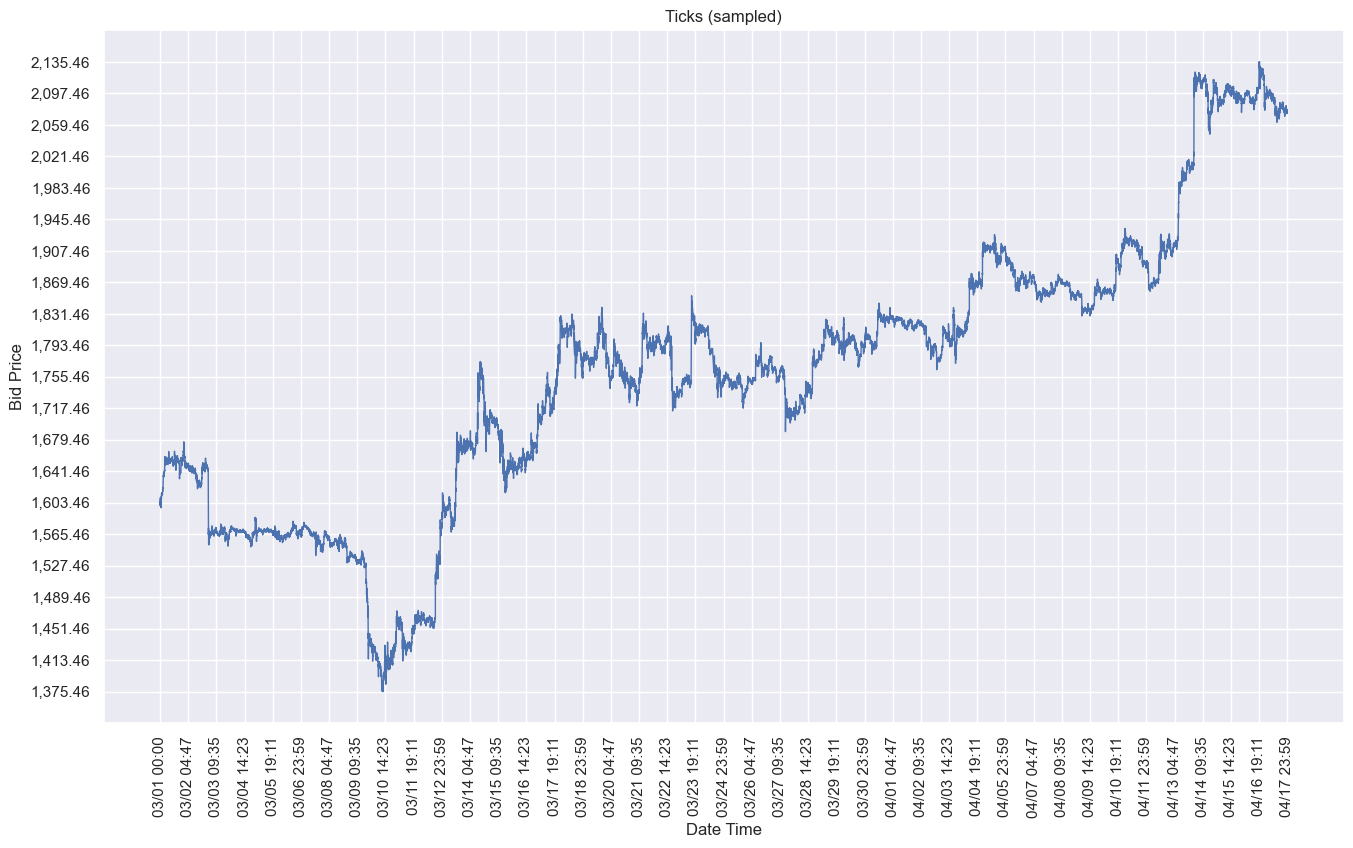

In [100]:
from IPython.core.display_functions import display

from binance.binance_k_line_loader import load_binance_k_lines
from binance.binance_tick_loader import load_binance_ticks
from chart.ttm_chart import draw_line_chart

k_lines = load_binance_k_lines(f"../../../ttm-data/{symbol}-{symbol_k_lines_interval}-*.csv")

ticks = load_binance_ticks(k_lines, symbol_ask_bid_price_difference)

draw_line_chart(ticks, 'timestamp', 'bid_price', 'Bid Price', 'Ticks')

display(ticks)

# Simulation Setup

In [101]:
# @formatter:off

In [102]:
%%time
# @formatter:on

from trade.trade_simulator import TradeSimulator

trade_simulator: TradeSimulator = TradeSimulator(ticks)

CPU times: user 52.1 s, sys: 818 ms, total: 52.9 s
Wall time: 53.2 s


# Simulation

'orders=30,049 price_step=0.10% avg_tick_price_change=0.06 tx_avg_price_margin=1.99 tx_avg_prof=0.02 tx_cum_prof=552.07'

'orders=5,753 price_step=0.25% avg_tick_price_change=0.06 tx_avg_price_margin=4.63 tx_avg_prof=-0.01 tx_cum_prof=-69.92'

'orders=1,543 price_step=0.50% avg_tick_price_change=0.06 tx_avg_price_margin=9.01 tx_avg_prof=-0.03 tx_cum_prof=-47.41'

'orders=683 price_step=0.75% avg_tick_price_change=0.06 tx_avg_price_margin=13.33 tx_avg_prof=-0.11 tx_cum_prof=-77.87'

'orders=380 price_step=1.00% avg_tick_price_change=0.06 tx_avg_price_margin=17.67 tx_avg_prof=0.67 tx_cum_prof=256.29'

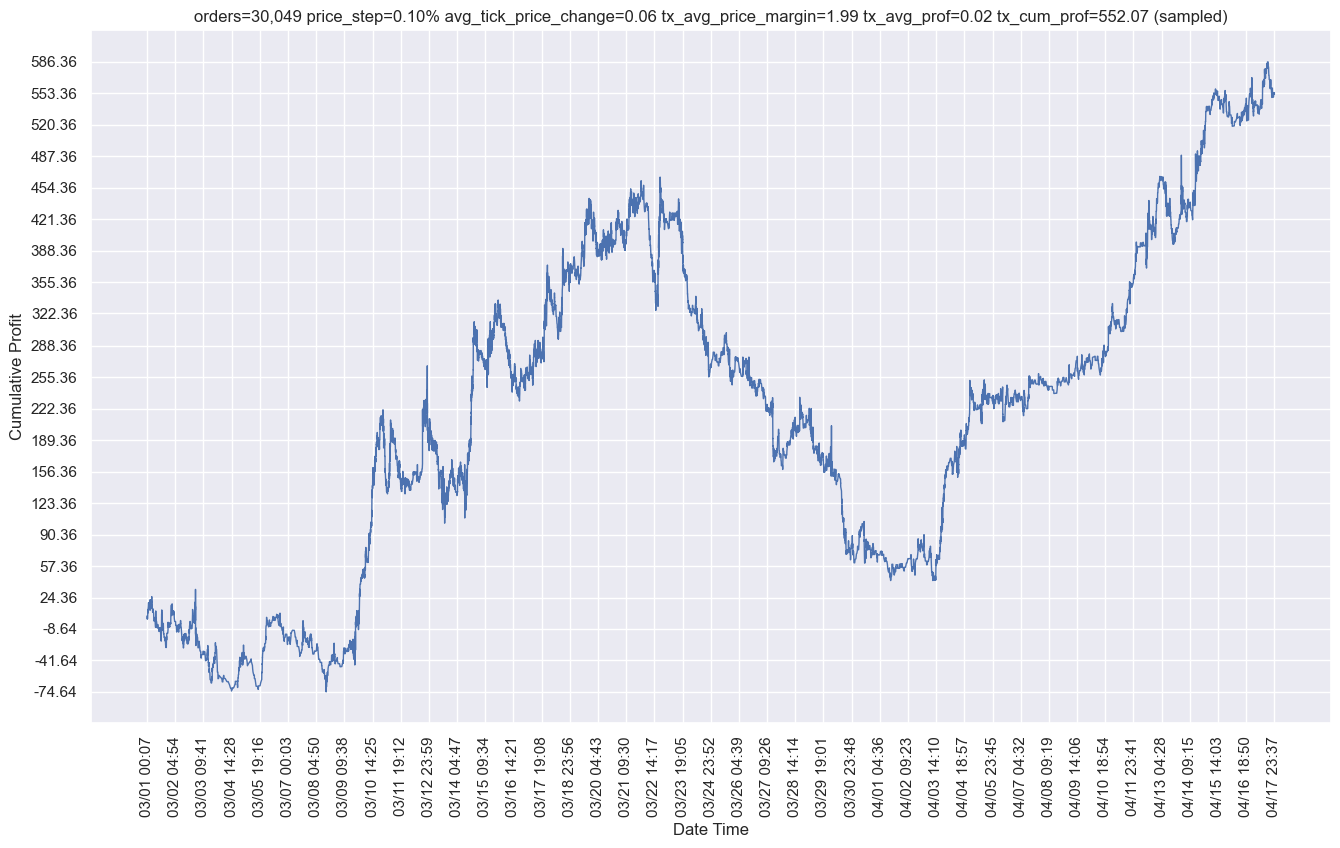

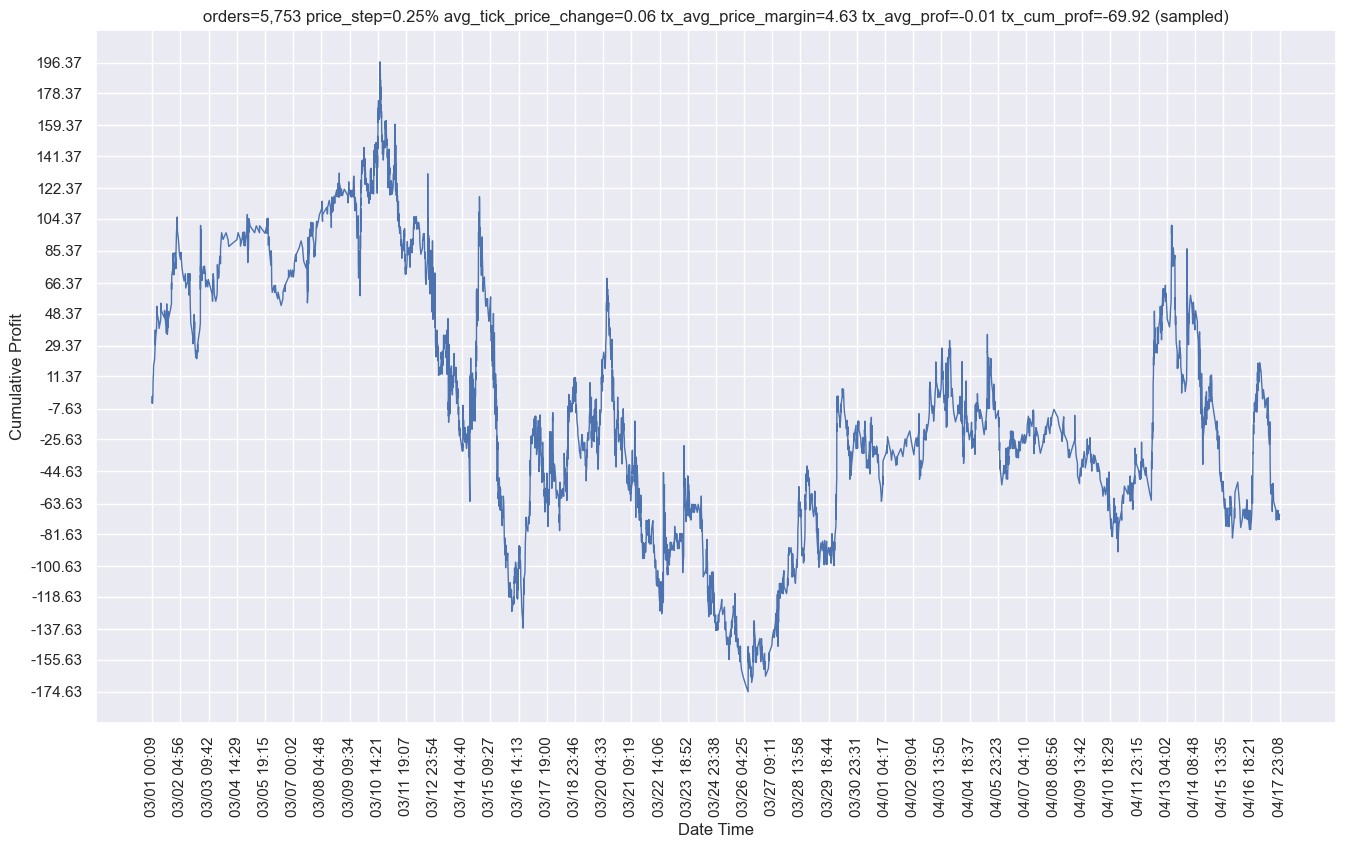

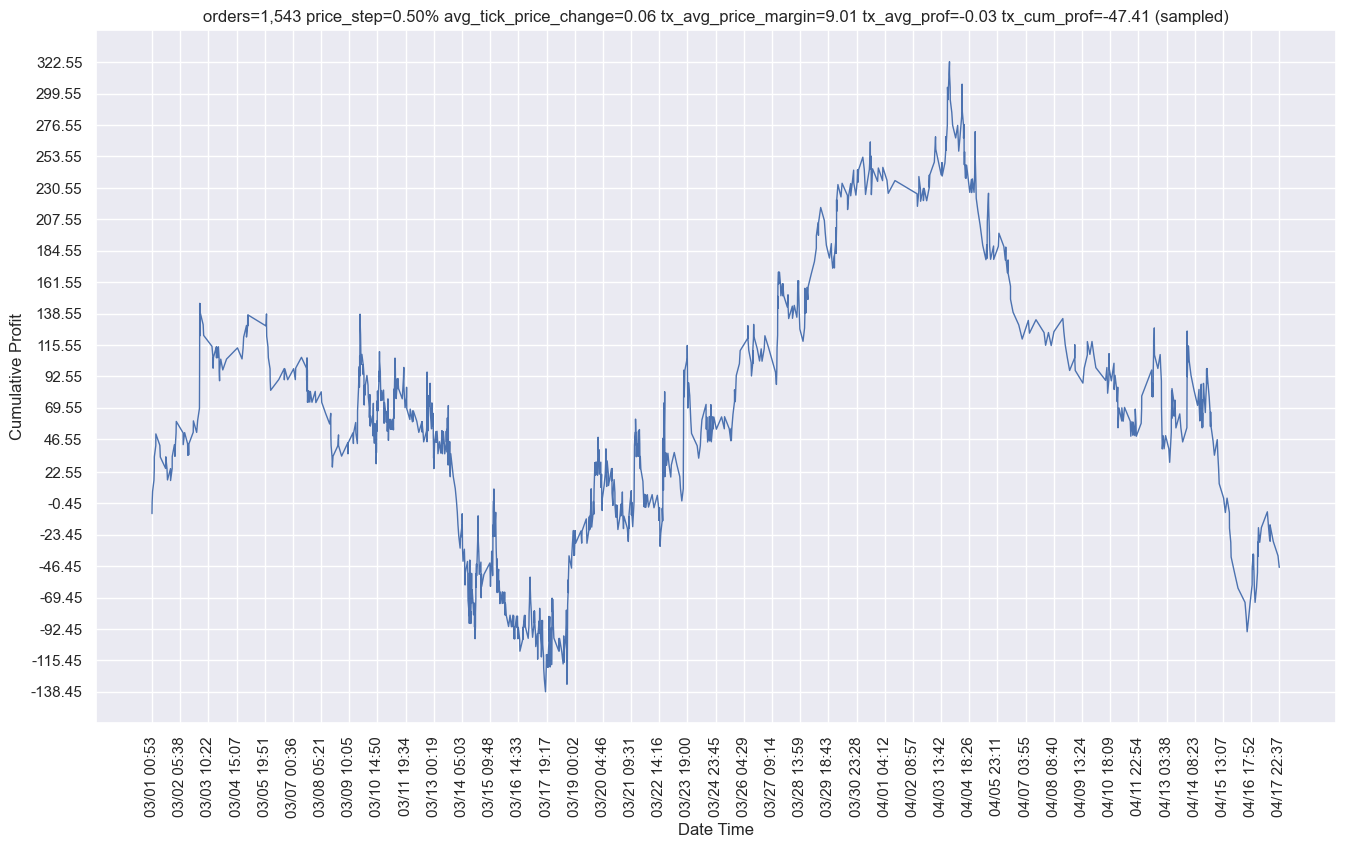

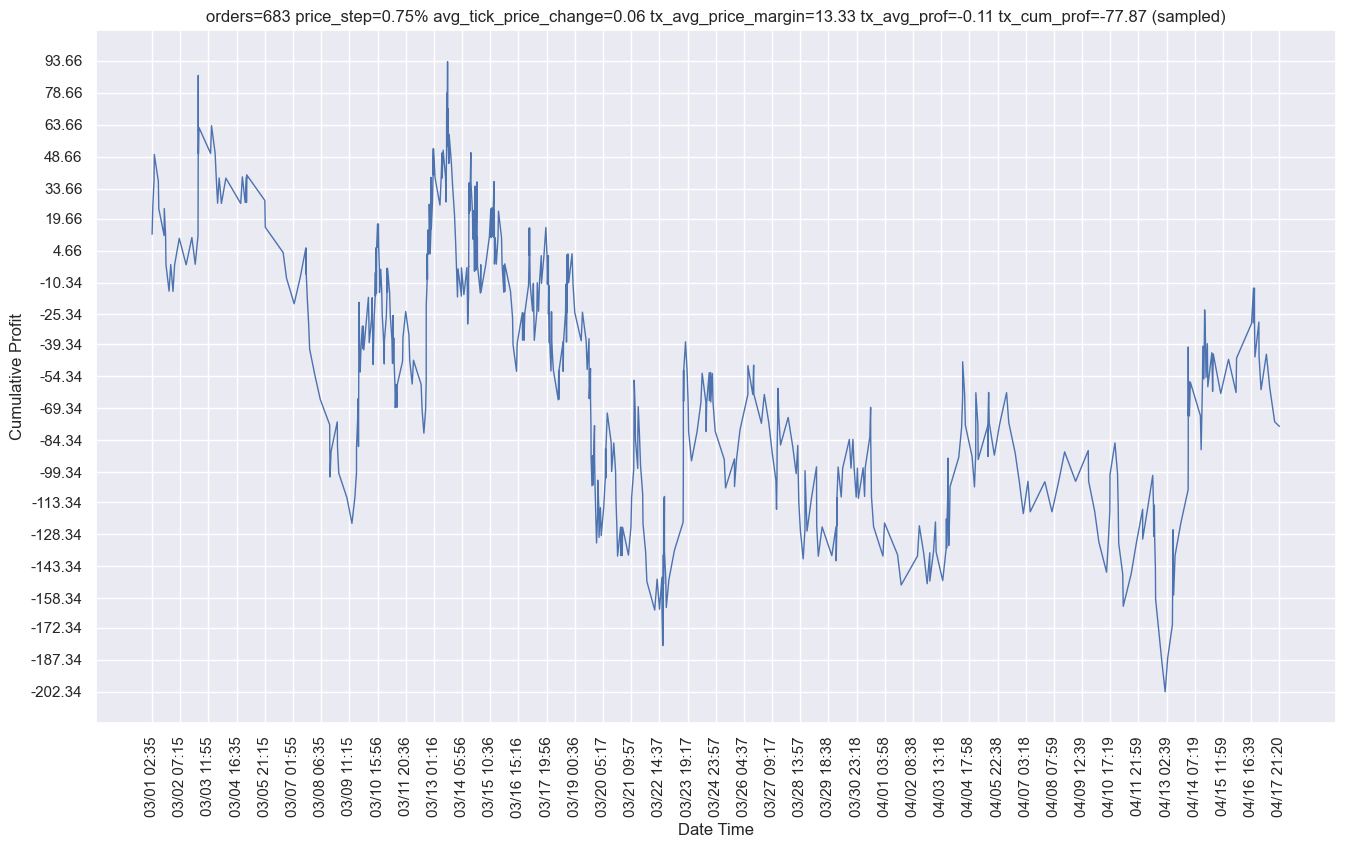

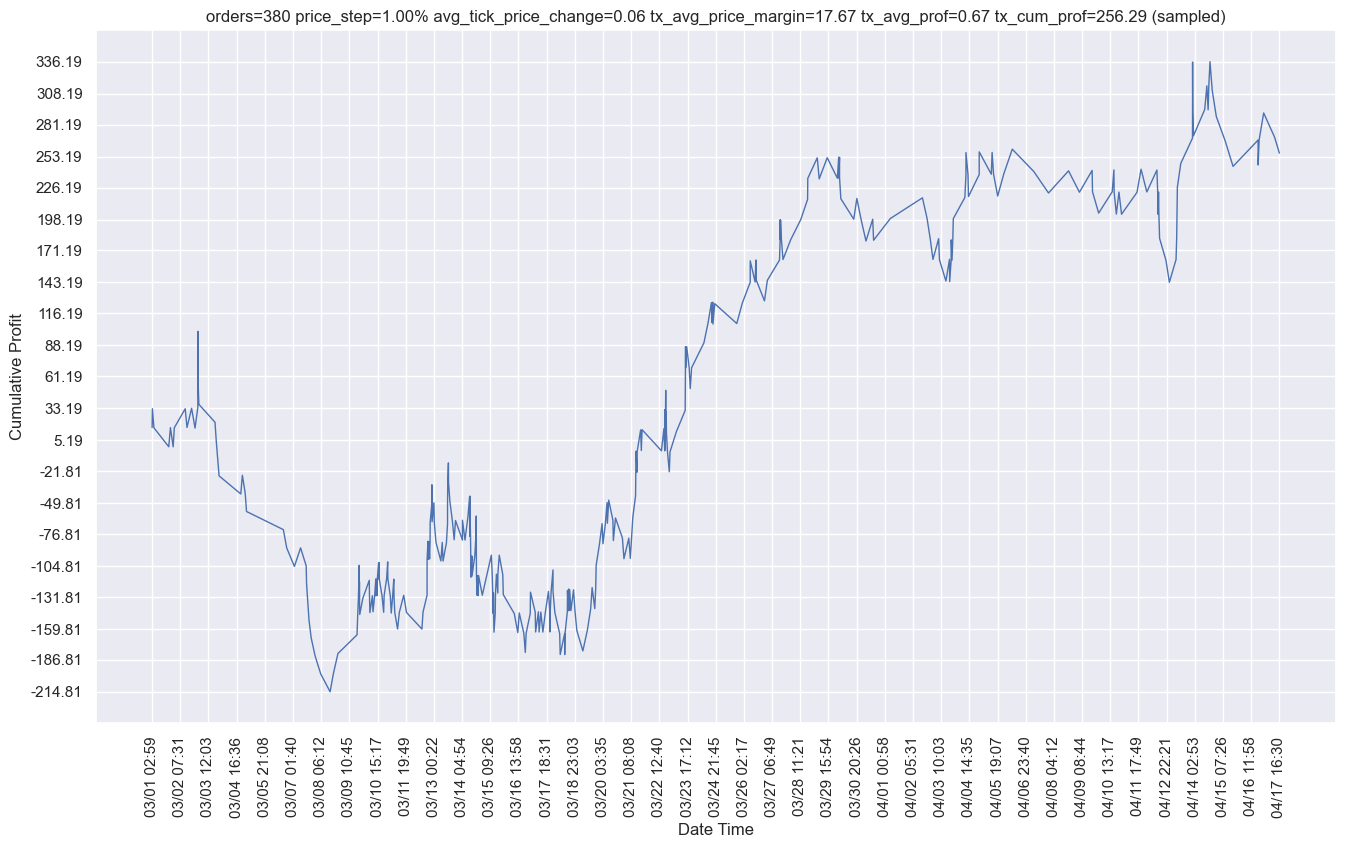

In [105]:
from bot.bot_0_strategy import Bot0Strategy

for price_step_ratio in [0.001, 0.0025, 0.005, 0.0075, 0.01]:
    transactions = trade_simulator.simulate(Bot0Strategy(price_step_ratio))
    # 'orders: 30,049, avg. price margin: 1.99, avg. profit: -0.04, cum. profit: -1199.56'
    result_str = (f"orders={len(transactions.index):,}"
                  f" price_step={price_step_ratio * 100:.2f}%"
                  f" avg_tick_price_change={ticks.ask_price.diff().abs().mean():.2f}"
                  f" tx_avg_price_margin={transactions.price_margin.mean():.2f}"
                  f" tx_avg_prof={transactions.profit.mean():.2f}"
                  f" tx_cum_prof={transactions.cumulative_profit.iloc[-1]:.2f}")
    draw_line_chart(transactions, 'open_timestamp', 'cumulative_profit', 'Cumulative Profit', result_str)
    display(result_str)
    # display(transactions)

